# Pylops - Marchenko redatuming with missing sources

### Author: M.Ravasi

In this notebook we consider to extensions of the Marchenko inversion in the presence of missing sources

In [1]:
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import bicgstab, lsqr
from scipy.signal import convolve, fftconvolve, filtfilt, hilbert

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 200         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

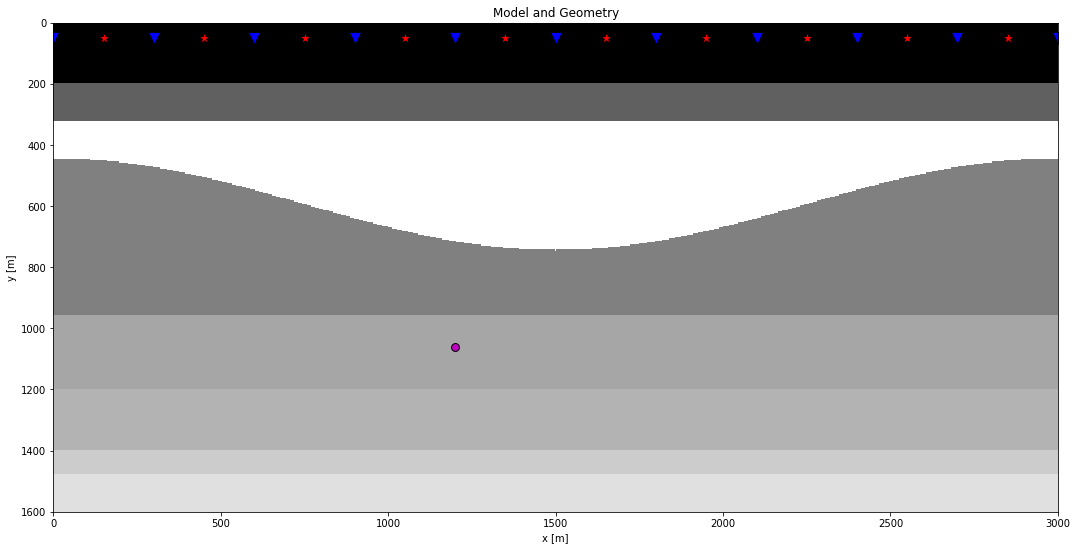

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
vs = inputdata['vs']

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
t2 = np.concatenate([-t[::-1], t[1:]])
ot, dt, nt, nt2 = t[0], t[1]-t[0], len(t), len(t2)

# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[s, r, f] assume particle velocity receiver and integrate over them (via reciprocity)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read subsurface fields and wavelet to apply to subsurface fields

In [6]:
Gsub = inputdata['Gsub'][:, ::jr]
G0sub = inputdata['G0sub'][:, ::jr]
#wav = inputdata['wav']
#wav_c = np.argmax(wav)
ntwav = 31
wav, twav, wav_c = ricker(t[:ntwav], 20)

# convolve with wavelet
Gsub = np.apply_along_axis(convolve, 0, Gsub, wav, mode='full')
Gsub = Gsub[wav_c:][:nt]
G0sub = np.apply_along_axis(convolve, 0, G0sub, wav, mode='full') 
G0sub = G0sub[wav_c:][:nt]

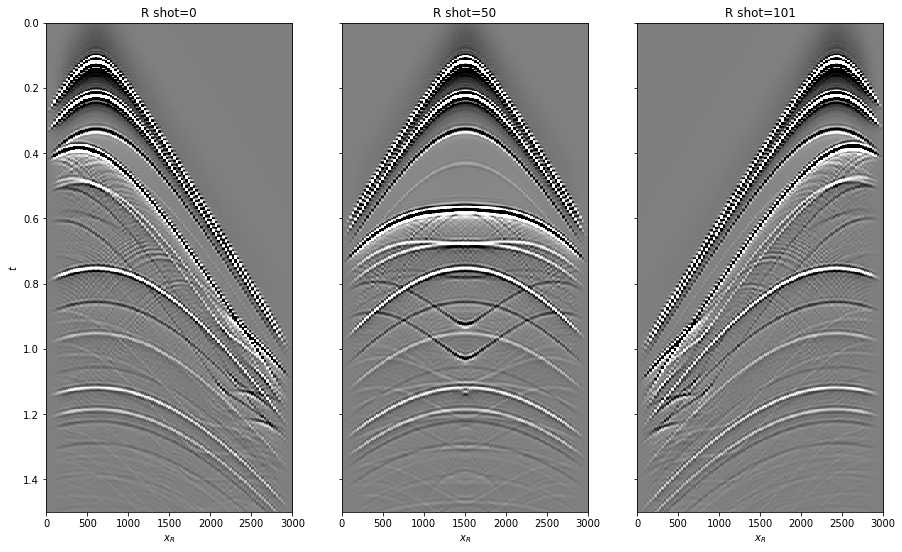

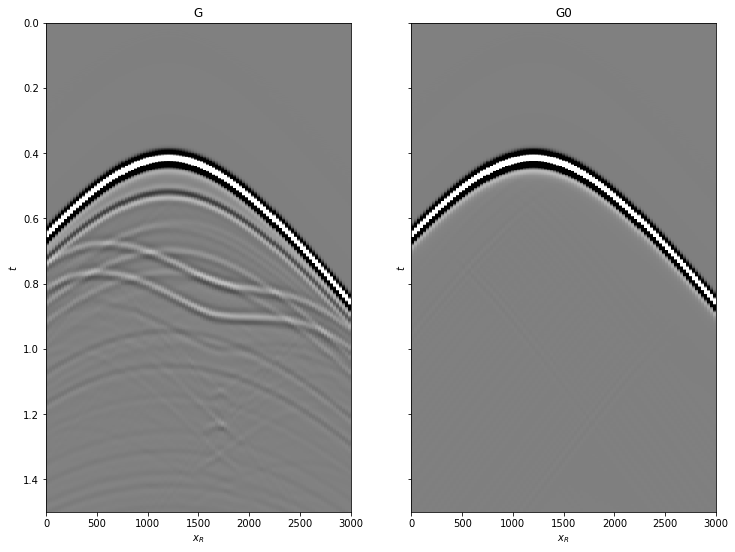

In [7]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 9))
axs[0].imshow(R[20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('R shot=0'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(R[ns//2].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('R shot=%d' %(ns//2)), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(R[-20].T, cmap='gray', vmin=-1e-2, vmax=1e-2, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title('R shot=%d' %ns), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight');
axs[2].set_ylim(1.5, 0)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(G0sub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('G0'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0);

## Marchenko preparation

Create window

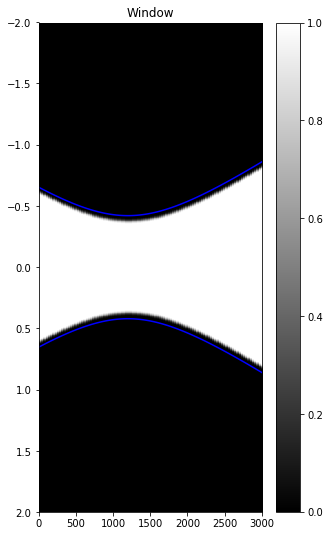

In [8]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel
directVS_off = directVS - toff

# window
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nt))
for ir in range(nr):
    w[ir, :idirectVS_off[ir]]=1            
w = np.hstack((np.fliplr(w), w[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    
    
fig, ax = plt.subplots(1, 1,  sharey=True, figsize=(5, 9))
im = ax.imshow(w.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax.plot(r[0], directVS,'b'),ax.plot(r[0], -directVS,'b')
ax.set_title('Window'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
ax.axis('tight')
fig.colorbar(im, ax=ax);

Create analytical direct wave

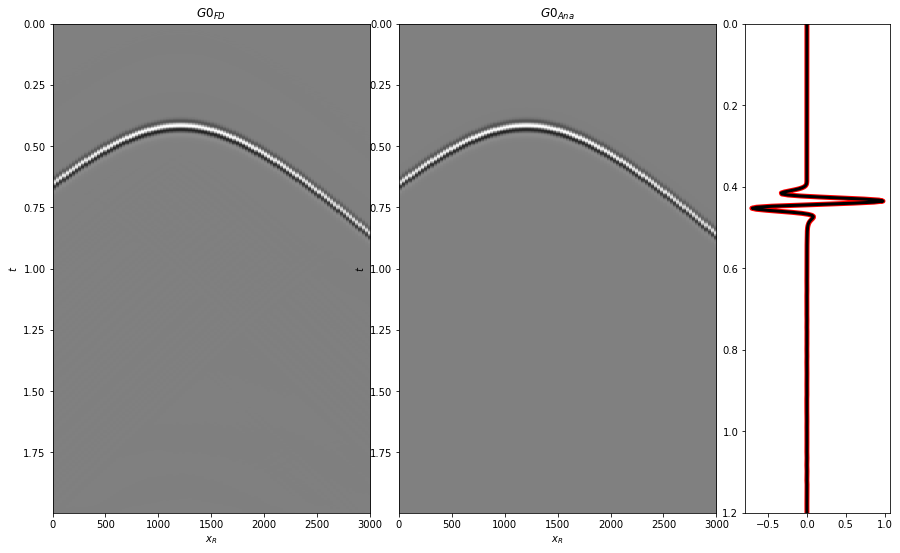

In [9]:
G0sub_ana = directwave(wav, directVS, nt, dt, nfft=2**11)

fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(G0sub/G0sub.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')

ax3.plot(G0sub[:, nr//2]/G0sub.max(), t, 'r', lw=5)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

## Marchenko with full sources

Let's start by creating benchmark responses

In [10]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * ns,
              dims=(2*nt-1, ns),
              dir=0, shift=-1)
Wsop = Diagonal(w.T.flatten())
Wrop = Diagonal(w.T.flatten())
Iop = Identity(nr*(2*nt-1))

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Mop = VStack([HStack([Iop, -1*Wsop*Rop]),
              HStack([-1*Wsop*Rollop*R1op, Iop])])*BlockDiag([Wrop, Wrop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

dottest(Gop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*ns*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=-190.105633 - u^T(Op^Tv)=-190.105633
Dot test passed, v^T(Opu)=130.507055 - u^T(Op^Tv)=130.507055


In [11]:
p0_minus = Rop * fd_plus.flatten()
p0_minus = p0_minus.reshape((2*nt-1), ns).T

d = Wsop*Rop*fd_plus.flatten()
d = np.concatenate((d.reshape(2*nt-1, ns), np.zeros((2*nt-1, ns))))

f1_adj = Mop.H*d.flatten()
f1_inv = lsqr(Mop, d.flatten(), iter_lim=10, show=True)[0]

f1_adj = f1_adj.reshape(2*nt2, nr)
f1_inv = f1_inv.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   322998 rows  and   322998 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.983e+07  2.983e+07    1.0e+00  3.5e-08
     1  0.00000e+00   1.311e+07  1.311e+07    4.4e-01  9.2e-01   1.1e+00  1.0e+00
     2  0.00000e+00   7.405e+06  7.405e+06    2.5e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   5.477e+06  5.477e+06    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   3.659e+06  3.659e+06    1.2e-01  3.3e-01   2.5e+00  5.2e+00
     5  0.00000e+00   2.778e+06  2.778e+06    9.3e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.242e+06  2.242e+06    7.5e-02  2.3e-01   3.2e+00  8.5e+00
     7  0.00000e+00   1.496e+06  1.496e+06    5.0e-02  2.5e-01   3.6e+00  1.1e+01
     8  0.00000e+00   1.103e

In [12]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, nr)), fd_plus))

g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), ns)
g_inv = g_inv.reshape(2*(2*nt-1), ns)

f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

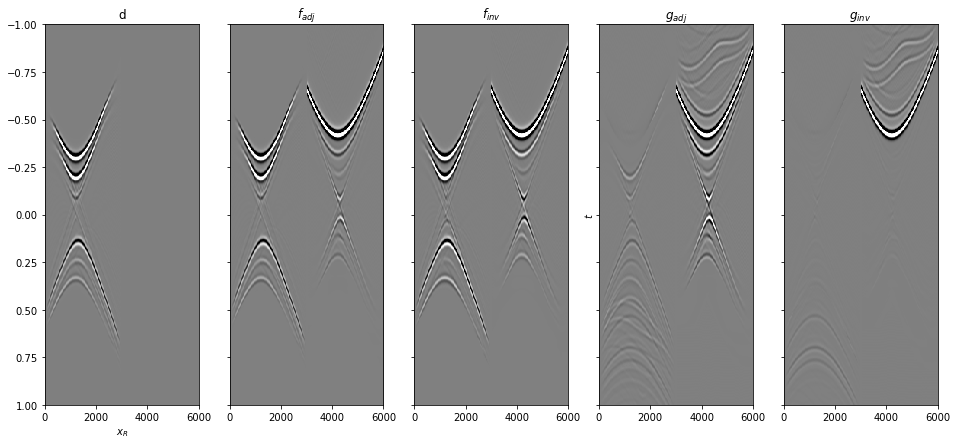

In [13]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_plot = np.concatenate((d[:(2*nt-1)], d[(2*nt-1):]), axis=1).T
f1_adj_tot_plot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot_plot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj_plot = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv_plot = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_S$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

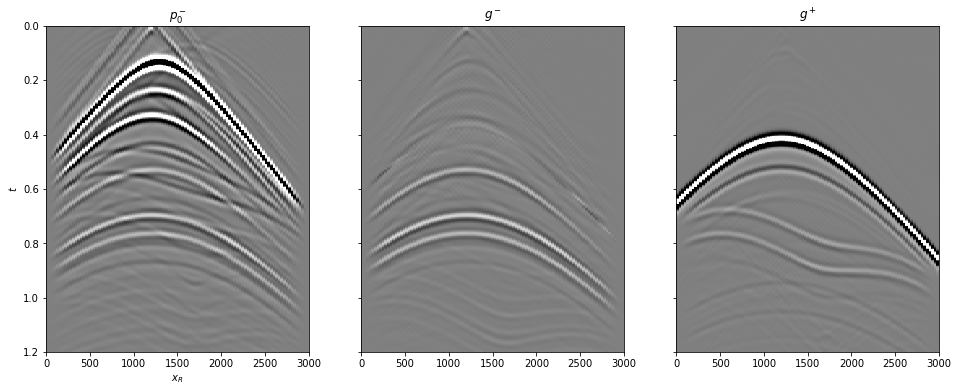

In [14]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.2, 0);
axs[1].imshow(g_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.2, 0);
axs[2].imshow(g_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.2, 0);

## Marchenko with missing sources

Let's consider the case of missing sources. We will restrict $R$ and at the same time replace the Identity operator with a Restriction operator along the main diagonal of the Marchenko operator.

$$
\begin{bmatrix}
   \Theta \mathbf{R_S} \mathbf{f_d^+}  \\
   \mathbf{0}
\end{bmatrix} =
\begin{bmatrix}
   \mathbf{S}  &   \Theta \mathbf{R_S}   \\
   \Theta \mathbf{R_S^*} & \mathbf{S}
\end{bmatrix}
\begin{bmatrix}
   \mathbf{f^-}  \\
   \mathbf{f_m^+}
\end{bmatrix}
$$
where $\mathbf{R_S}$ is a restricted reflection response (i.e., only with available sources)
To be able to deal with missing sources (and gaps in the retrieved focusing functions) we will use a sliding linear Radon sparsity transform and L1 solver FISTA.

In [15]:
# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((ns, nr, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, s, r]

# subsampling
perc_subsampling=0.6
nsava=int(np.round(ns*perc_subsampling))
ishuffle = np.random.permutation(np.arange(ns))
iava = np.sort(ishuffle[:nsava])
inotava = np.sort(ishuffle[nsava:])
Rtwosided_fft = Rtwosided_fft[:, iava]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, dtype='complex64')
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, twosided=True, transpose=False, conj=True, dtype='complex64')
Rollop = Roll((2*nt-1) * nsava,
              dims=(2*nt-1, nsava),
              dir=0, shift=-1)
Restrop = Restriction(ns*(2*nt-1), iava, dims=(2*nt-1, ns), dir=1, dtype='float64')
Wsop = Diagonal(w[iava].T.flatten())
Wrop = Diagonal(w.T.flatten())

# Input focusing function
fd_plus =  np.concatenate((np.fliplr(G0sub.T).T, np.zeros((nt-1, nr))))

Create Marchenko operator

In [16]:
Mop = VStack([HStack([Restrop, -1*Wsop*Rop]),
              HStack([-1*Wsop*Rollop*R1op, Restrop])])*BlockDiag([Wrop, Wrop])
Gop = VStack([HStack([Restrop, -1*Rop]),
              HStack([-1*Rollop*R1op, Restrop])])

dottest(Gop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True)
dottest(Mop, 2*nsava*(2*nt-1), 2*nr*(2*nt-1), verb=True);

Dot test passed, v^T(Opu)=304.405361 - u^T(Op^Tv)=304.405361
Dot test passed, v^T(Opu)=40.589038 - u^T(Op^Tv)=40.589038


Run standard redatuming as benchmark

In [17]:
p0_minus_sub = Rop * fd_plus.flatten()
p0_minus_sub = p0_minus_sub.reshape((2*nt-1), nsava).T

Create data, adjoint and inverse focusing functions

In [18]:
d_sub = Wsop*Rop*fd_plus.flatten()
d_sub = np.concatenate((d_sub.reshape(2*nt-1, nsava), np.zeros((2*nt-1, nsava))))

f1_adj_sub = Mop.H*d_sub.flatten()
f1_inv_sub = lsqr(Mop, d_sub.flatten(), iter_lim=n_iter, show=True)[0]

f1_adj_sub = f1_adj_sub.reshape(2*nt2, nr)
f1_inv_sub = f1_inv_sub.reshape(2*nt2, nr)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has   195078 rows  and   322998 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.355e+07  2.355e+07    1.0e+00  4.4e-08
     1  0.00000e+00   8.020e+06  8.020e+06    3.4e-01  1.0e+00   1.1e+00  1.0e+00
     2  0.00000e+00   3.818e+06  3.818e+06    1.6e-01  4.8e-01   1.7e+00  2.1e+00
     3  0.00000e+00   2.371e+06  2.371e+06    1.0e-01  4.2e-01   2.1e+00  3.3e+00
     4  0.00000e+00   1.251e+06  1.251e+06    5.3e-02  3.6e-01   2.4e+00  4.8e+00
     5  0.00000e+00   7.989e+05  7.989e+05    3.4e-02  2.9e-01   2.7e+00  6.1e+00
     6  0.00000e+00   5.466e+05  5.466e+05    2.3e-02  3.0e-01   3.0e+00  7.6e+00
     7  0.00000e+00   3.623e+05  3.623e+05    1.5e-02  2.5e-01   3.3e+00  9.2e+00
     8  0.00000e+00   2.583e

Add initial guess to estimated focusing functions

In [19]:
f1_adj_sub_tot = f1_adj_sub + np.concatenate((np.zeros((2*nt-1, nr)),
                                      np.concatenate((np.fliplr(G0sub.T).T, 
                                                      np.zeros((nt-1, nr))), axis=0)))

f1_inv_sub_tot = f1_inv_sub + np.concatenate((np.zeros((2*nt-1, nr)), fd_plus))

Estimate Green's functions

In [20]:
g_adj_sub = Gop*f1_adj_sub_tot.flatten()
g_inv_sub = Gop*f1_inv_sub_tot.flatten()

g_adj_sub = g_adj_sub.reshape(2*(2*nt-1), nsava)
g_inv_sub = g_inv_sub.reshape(2*(2*nt-1), nsava)

Extract up and down focusing and Green's functions from model vectors

In [21]:
f1_adj_sub_minus, f1_adj_sub_plus =  f1_adj_sub_tot[:(2*nt-1)].T, f1_adj_sub_tot[(2*nt-1):].T
f1_inv_sub_minus, f1_inv_sub_plus =  f1_inv_sub_tot[:(2*nt-1)].T, f1_inv_sub_tot[(2*nt-1):].T

g_adj_sub_minus, g_adj_sub_plus =  -g_adj_sub[:(2*nt-1)].T, np.fliplr(g_adj_sub[(2*nt-1):].T)
g_inv_sub_minus, g_inv_sub_plus =  -g_inv_sub[:(2*nt-1)].T, np.fliplr(g_inv_sub[(2*nt-1):].T)

g_inv_sub_tot = g_inv_sub_minus + g_inv_sub_plus

Visualization

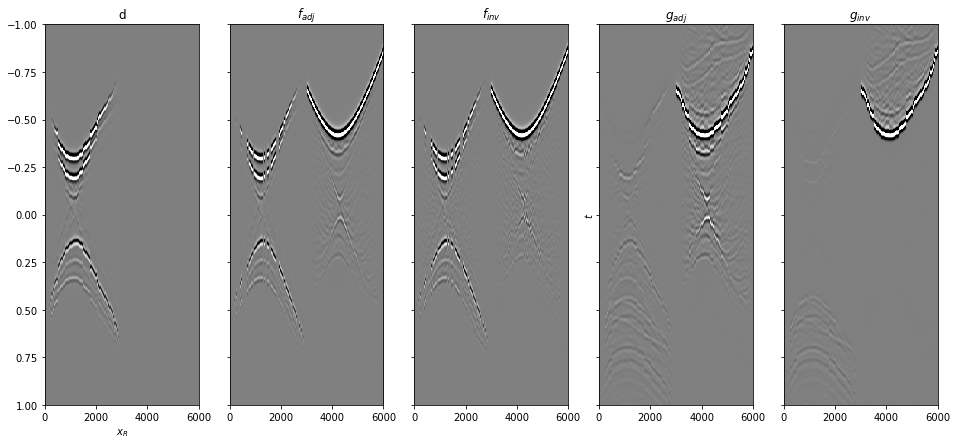

In [22]:
# Need to recreate combined data as new implementation stacks over time instead of space
d_sub_plot = np.concatenate((d_sub[:(2*nt-1)], d_sub[(2*nt-1):]), axis=1).T
f1_adj_sub_tot_plot = np.concatenate((f1_adj_sub_tot[:(2*nt-1)], f1_adj_sub_tot[(2*nt-1):]), axis=1).T
f1_inv_sub_tot_plot = np.concatenate((f1_inv_sub_tot[:(2*nt-1)], f1_inv_sub_tot[(2*nt-1):]), axis=1).T
g_adj_sub_plot = np.concatenate((g_adj_sub[:(2*nt-1)], g_adj_sub[(2*nt-1):]), axis=1).T
g_inv_sub_plot = np.concatenate((g_inv_sub[:(2*nt-1)], g_inv_sub[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_sub_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_S$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_adj_sub_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[0].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_sub_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_adj_sub_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_inv_sub_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

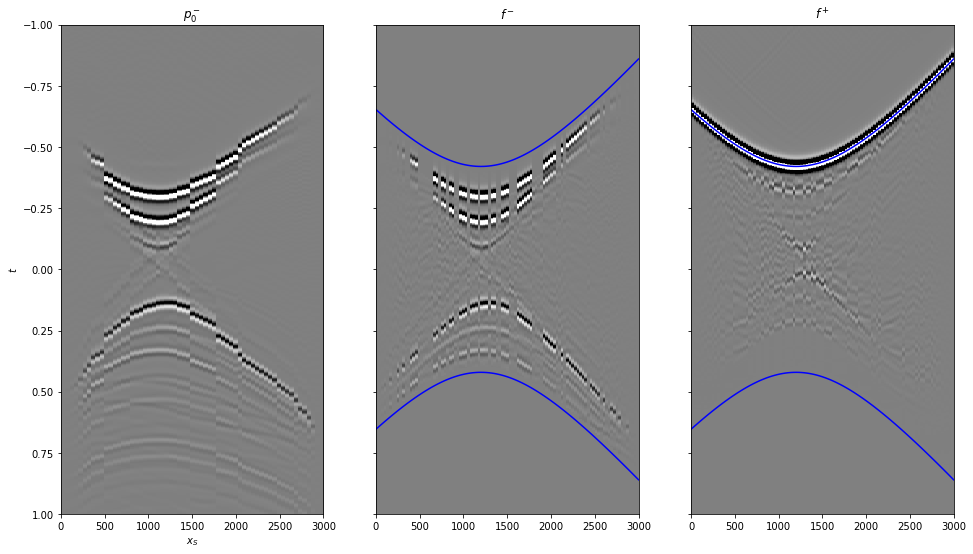

In [23]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus_sub.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_sub_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S$')
axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_sub_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_S$')
axs[2].plot(r[0], directVS,'b'),axs[2].plot(r[0], -directVS,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

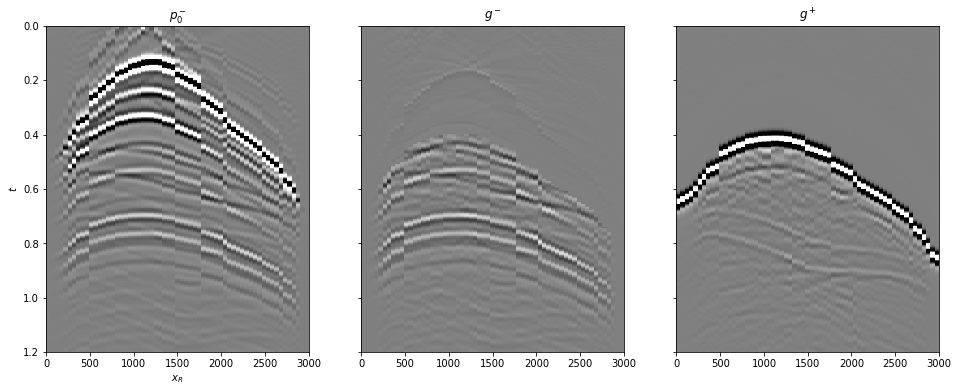

In [24]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 6))
axs[0].imshow(p0_minus_sub.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1.2, 0);
axs[1].imshow(g_inv_sub_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1.2, 0);
axs[2].imshow(g_inv_sub_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1.2, 0);

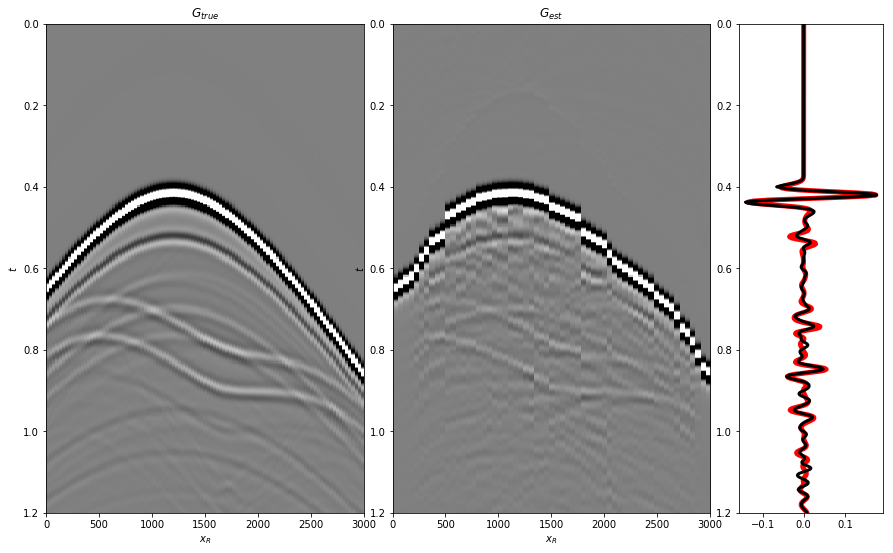

In [25]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(Gsub, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_sub_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)

ax3.plot(t**2*Gsub[:, iava][:, nr//4]/Gsub.max(), t, 'r', lw=5)
ax3.plot(t**2*g_inv_sub_tot[nr//4, nt-1:]/g_inv_tot.max(), t, 'k', lw=3)
ax3.set_ylim(1.2, 0);

Extract focusing functions at locations where sources are not available

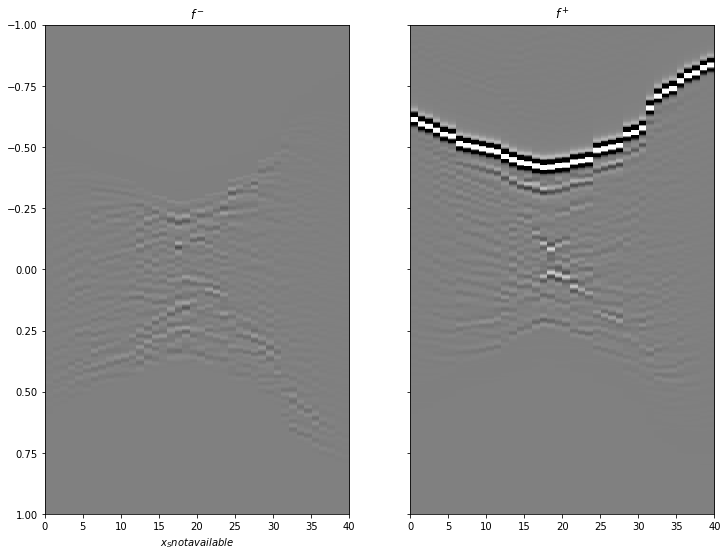

In [26]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 9))
axs[0].imshow(f1_inv_sub_minus[inotava].T, cmap='gray', 
              vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_S not available$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_sub_plus[inotava].T, cmap='gray', 
              vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_S not available$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

### Radon reconstruction

We try now to express the focusing functions as local linear events in an attempt to fill the gaps

In [27]:
nwin=25
nwins=6
nover=10
npx=101
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
dimsd = (nr, nt2) 
dimss = (nwins*npx, dimsd[1])

# tranpose operator
Top = Transpose((nt2, nr), axes=(1, 0), dtype=np.float64)

# sliding window radon with overlap
RadOp = Radon2D(t2, np.linspace(-dr*nwin//2, dr*nwin//2, nwin), px, centeredh=True,
                kind='linear', engine='numba')
Slidop = Sliding2D(RadOp, dimss, dimsd, nwin, nover, tapertype='cosine', design=False)
dottest(Slidop, np.prod(dimsd), np.prod(dimss), verb=True);

Sparseop = BlockDiag([Top.H*Slidop, Top.H*Slidop])
Mop_radon = Mop * Sparseop
dottest(Mop_radon, 2*nsava*(2*nt-1), 2*np.prod(dimss), verb=True);

Dot test passed, v^T(Opu)=774.459851 - u^T(Op^Tv)=774.459851
Dot test passed, v^T(Opu)=-1055.203600 - u^T(Op^Tv)=-1055.203600


Forward and adjoint Radon

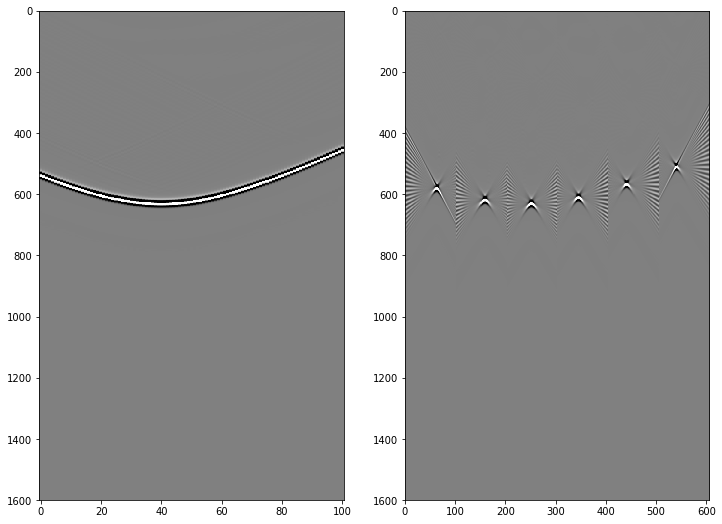

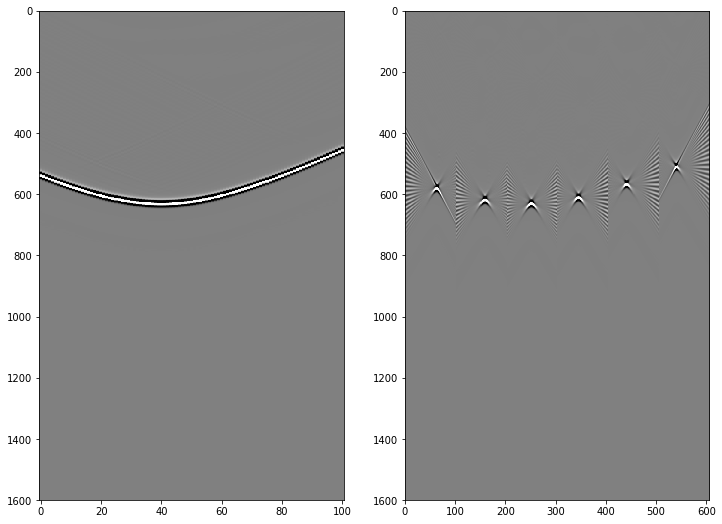

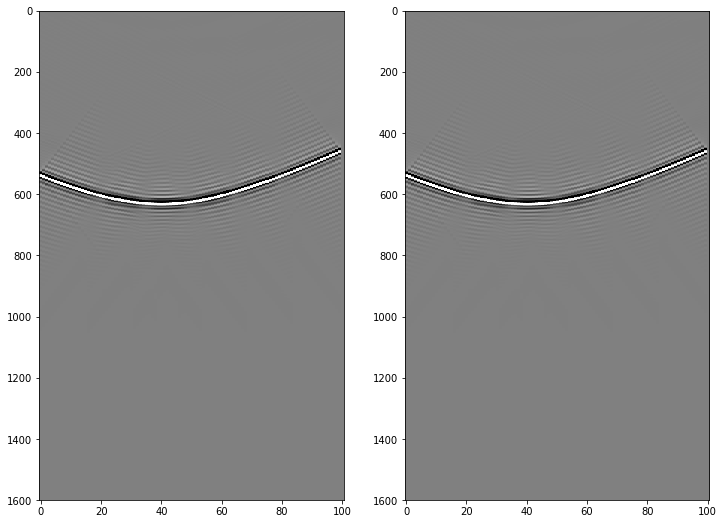

In [28]:
fd_plus1 = np.concatenate([fd_plus, fd_plus])
fd_plus1_radon = Sparseop.H*fd_plus1.flatten()
fd_plus2_radon = Sparseop * fd_plus1_radon

fd_plus1_radon = fd_plus1_radon.reshape(2*npx*nwins, nt2)
fd_plus2_radon = fd_plus2_radon.reshape(2*nt2, nr)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus1[:nt2], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon[:npx*nwins].T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus1[nt2:], cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(fd_plus1_radon[npx*nwins:].T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight');

fig, axs = plt.subplots(1, 2, figsize=(12, 9))
axs[0].imshow(fd_plus2_radon[nt2:], cmap='gray', vmin=-5e7, vmax=5e7)
axs[0].axis('tight')
axs[1].imshow(fd_plus2_radon[:nt2], cmap='gray', vmin=-5e7, vmax=5e7)
axs[1].axis('tight');

And on one of the previously found solutions (upgoing focusing function)

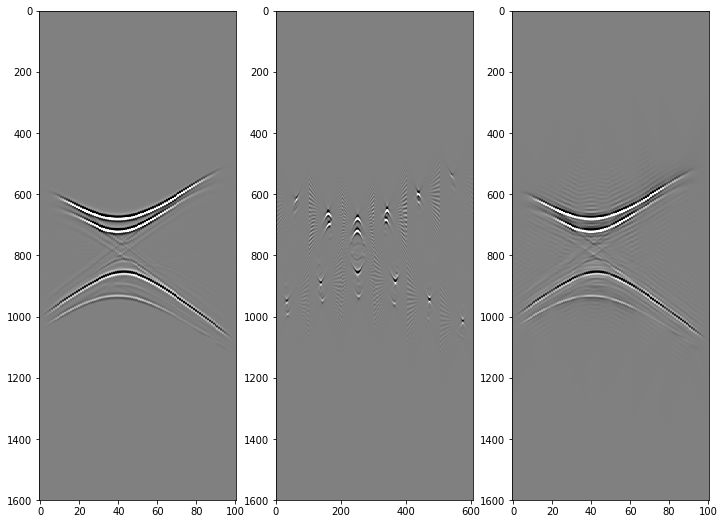

In [29]:
f1_minus_radon = Slidop.H * f1_inv_minus.flatten()
f1_minus_rec = Slidop * f1_minus_radon
f1_minus_radon = f1_minus_radon.reshape(npx*nwins, nt2)
f1_minus_rec = f1_minus_rec.reshape(nr, nt2)

fig, axs = plt.subplots(1, 3, figsize=(12, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5)
axs[0].axis('tight')
axs[1].imshow(f1_minus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6)
axs[1].axis('tight');
axs[2].imshow(f1_minus_rec.T, cmap='gray', vmin=-5e7, vmax=5e7)
axs[2].axis('tight');

In [31]:
f1_radon_inv = FISTA(Mop_radon, d_sub.flatten(), eps=1e4, niter=n_iter*2, 
                     alpha = 1.05e-3, #eigsiter=4, eigstol=1e-3, 
                     returninfo=False, show=True)[0]
f1_radon_inv = Sparseop * f1_radon_inv

f1_radon_inv = f1_radon_inv.reshape(2*nt2, nr)

FISTA optimization (soft thresholding)
-----------------------------------------------------------
The Operator Op has 195078 rows and 1937988 cols
eps = 1.000000e+04	tol = 1.000000e-10	niter = 400
alpha = 1.050000e-03	thresh = 5.250000e+00
-----------------------------------------------------------

   Itn       x[0]        r2norm     r12norm     xupdate
     1   0.00000e+00   2.312e+14   2.318e+14   2.258e+05
     2   0.00000e+00   1.942e+14   1.954e+14   2.016e+05
     3   0.00000e+00   1.565e+14   1.583e+14   2.319e+05
     4   0.00000e+00   1.214e+14   1.238e+14   2.491e+05
     5   0.00000e+00   9.097e+13   9.400e+13   2.552e+05
     6   0.00000e+00   6.607e+13   6.974e+13   2.522e+05
     7   0.00000e+00   4.668e+13   5.096e+13   2.422e+05
     8   0.00000e+00   3.225e+13   3.710e+13   2.271e+05
     9   0.00000e+00   2.193e+13   2.732e+13   2.087e+05
    10   0.00000e+00   1.481e+13   2.070e+13   1.884e+05
    11   0.00000e+00   1.006e+13   1.639e+13   1.677e+05
    21   0.0000

In [32]:
f1_radon_inv_tot = f1_radon_inv + np.concatenate((np.zeros((nt2, nr)), fd_plus))

g_radon_inv = Gop*f1_radon_inv_tot.flatten()
g_radon_inv = g_radon_inv.reshape(2*(2*nt-1), nsava)

f1_radon_inv_minus, f1_radon_inv_plus =  f1_radon_inv_tot[:(2*nt-1)].T, f1_radon_inv_tot[(2*nt-1):].T
g_radon_inv_minus, g_radon_inv_plus =  -g_radon_inv[:(2*nt-1)].T, np.fliplr(g_radon_inv[(2*nt-1):].T)

g_radon_inv_tot = g_radon_inv_minus + g_radon_inv_plus

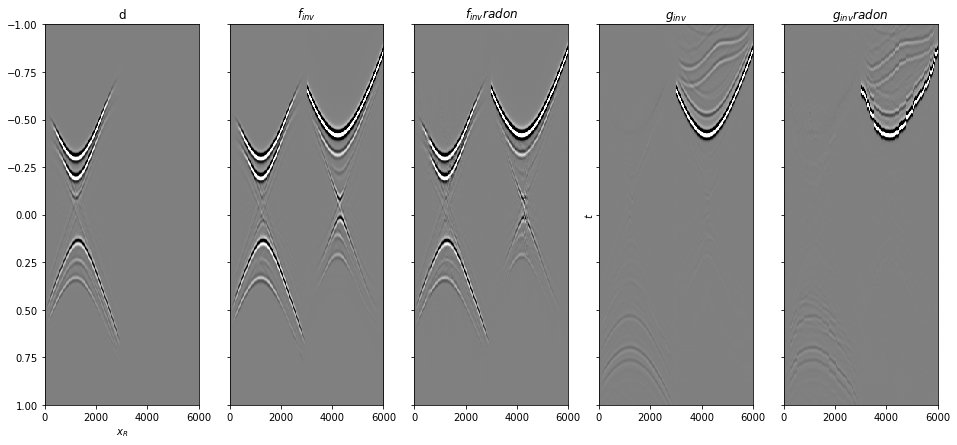

In [33]:
# Need to recreate combined data as new implementation stacks over time instead of space
f1_radon_inv_tot_plot = np.concatenate((f1_radon_inv_tot[:(2*nt-1)], f1_radon_inv_tot[(2*nt-1):]), axis=1).T
g_radon_inv_plot = np.concatenate((g_radon_inv[:(2*nt-1)], g_radon_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(f1_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_radon_inv_tot_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{inv}$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(1, -1);
axs[4].imshow(g_radon_inv_plot.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv} radon$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1, -1);

Compare with benchmark focusing functions (from regularly sampled data)

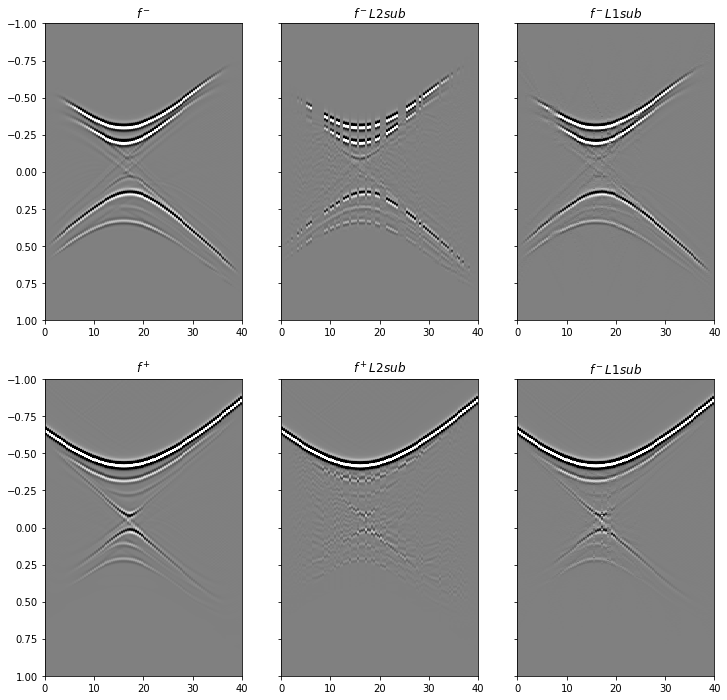

In [34]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 12))
axs[0][0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1);
axs[0][1].imshow(f1_inv_sub_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][1].set_title(r'$f^- L2sub$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1)
axs[0][2].imshow(f1_radon_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][2].set_title(r'$f^- L1sub$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1, -1)
axs[1][0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^+$')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1);
axs[1][1].imshow(f1_inv_sub_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+ L2sub$')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1);
axs[1][2].imshow(f1_radon_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^- L1sub$')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1, -1);

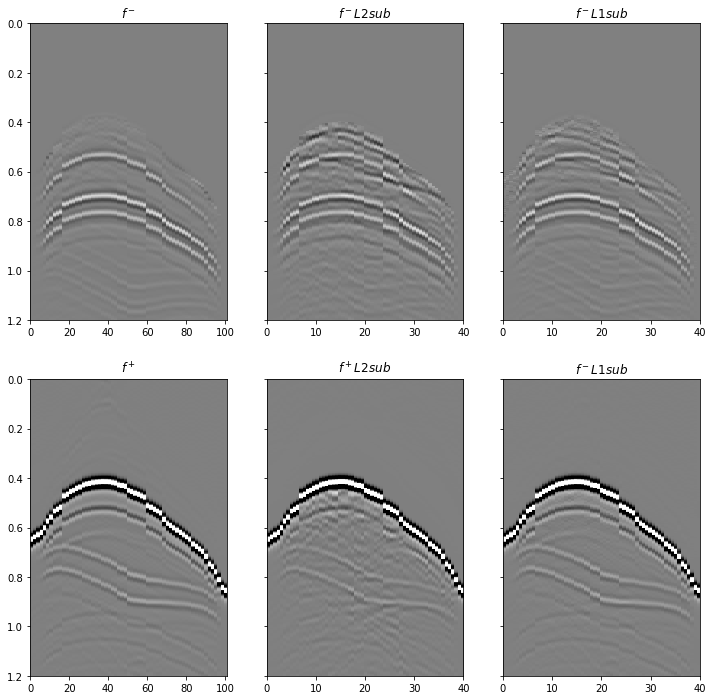

In [35]:
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(12, 12))
axs[0][0].imshow((1-w[iava].T)*g_inv_minus[iava].T, cmap='gray', vmin=-1e5, vmax=1e5, 
                 extent=(0, ns, t[-1], -t[-1]))
axs[0][0].set_title(r'$f^-$')
axs[0][0].axis('tight')
axs[0][1].imshow((1-w[iava].T)*g_inv_sub_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][1].set_title(r'$f^- L2sub$')
axs[0][1].axis('tight')
axs[0][2].imshow((1-w[iava].T)*g_radon_inv_minus.T, cmap='gray', vmin=-1e5, vmax=1e5, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0][2].set_title(r'$f^- L1sub$')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1.2, 0)
axs[1][0].imshow(g_inv_plus[iava].T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(0, ns, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^+$')
axs[1][0].axis('tight')
axs[1][1].imshow(g_inv_sub_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^+ L2sub$')
axs[1][1].axis('tight')
axs[1][2].imshow(g_radon_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
                 extent=(0, ns-nsava, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^- L1sub$')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1.2, 0);

And in the Radon domain

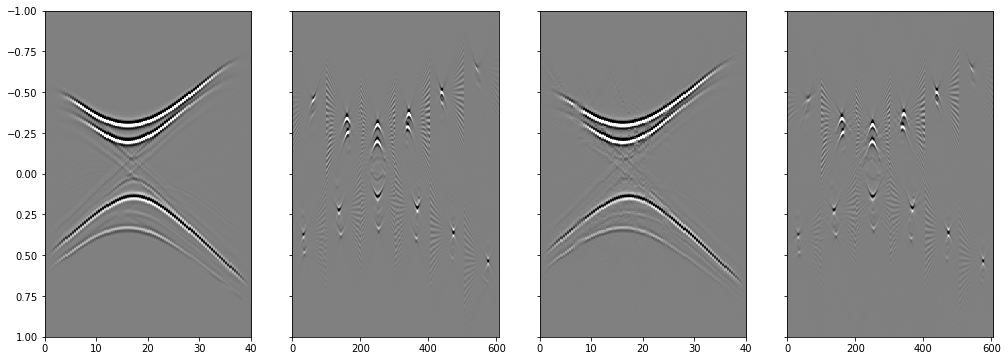

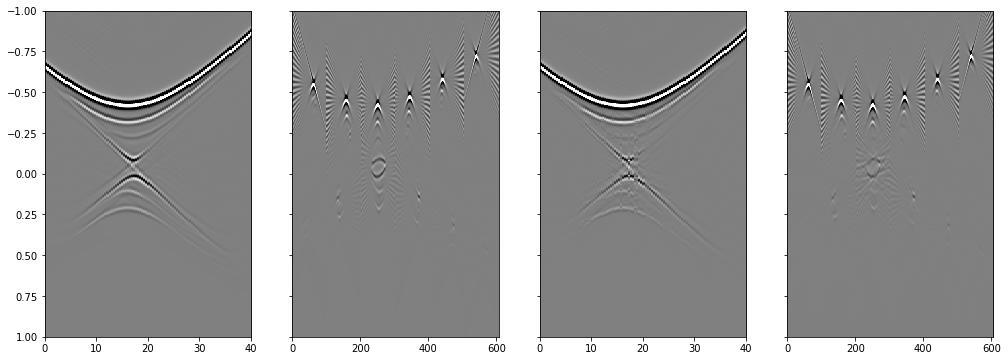

In [36]:
f1_inv_minus_radon = Slidop.H * f1_inv_minus.flatten()
f1_inv_minus_radon = f1_inv_minus_radon.reshape(npx*nwins, nt2)

f1_radon_inv_minus_radon = Slidop.H * f1_radon_inv_minus.flatten()
f1_radon_inv_minus_radon = f1_radon_inv_minus_radon.reshape(npx*nwins, nt2)

f1_inv_plus_radon = Slidop.H * f1_inv_plus.flatten()
f1_inv_plus_radon = f1_inv_plus_radon.reshape(npx*nwins, nt2)

f1_radon_inv_plus_radon = Slidop.H * f1_radon_inv_plus.flatten()
f1_radon_inv_plus_radon = f1_radon_inv_plus_radon.reshape(npx*nwins, nt2)


fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].axis('tight')
axs[1].imshow(f1_inv_minus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].axis('tight');
axs[2].imshow(f1_radon_inv_minus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[2].axis('tight')
axs[3].imshow(f1_radon_inv_minus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_ylim(1, -1);

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(17, 6))
axs[0].imshow(f1_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[0].axis('tight')
axs[1].imshow(f1_inv_plus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[1].axis('tight');
axs[2].imshow(f1_radon_inv_plus.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(0, ns-nsava, t[-1], -t[-1]))
axs[2].axis('tight')
axs[3].imshow(f1_radon_inv_plus_radon.T, cmap='gray', vmin=-5e6, vmax=5e6, 
              extent=(0, nwins*npx, t[-1], -t[-1]))
axs[3].axis('tight')
axs[3].set_ylim(1, -1);

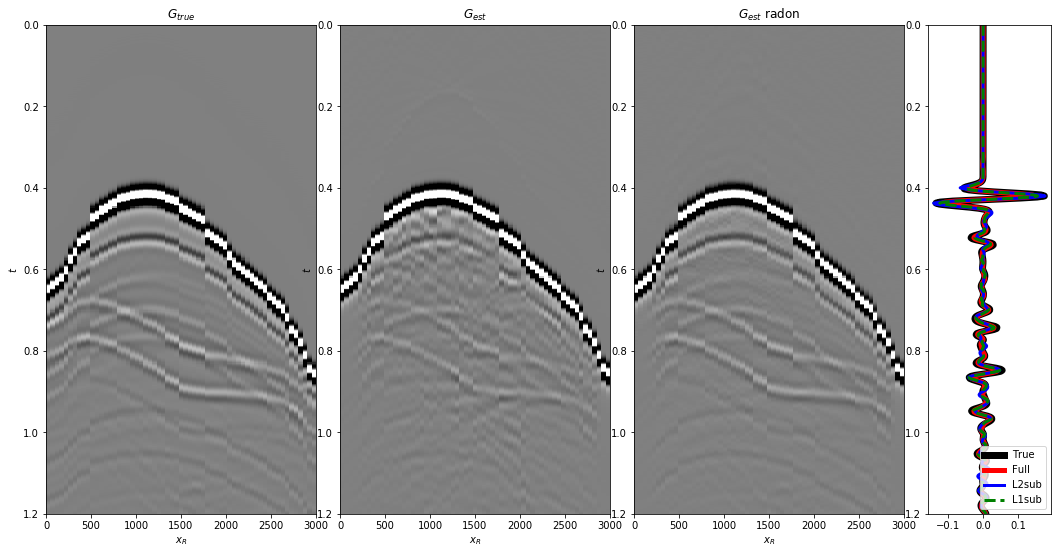

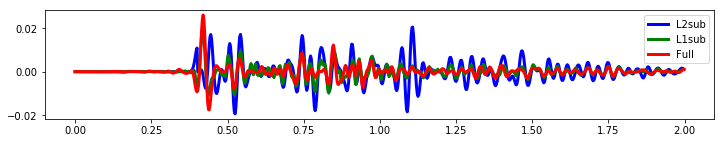

In [37]:
fig = plt.figure(figsize=(18,9))
ax1 = plt.subplot2grid((1, 7), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 7), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 7), (0, 4), colspan=2)
ax4 = plt.subplot2grid((1, 7), (0, 6))

ax1.imshow(Gsub[:, iava], cmap='gray', vmin=-5e5, vmax=5e5, extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(1.2, 0)
ax2.imshow(g_inv_sub_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(1.2, 0)
ax3.imshow(g_radon_inv_tot.T, cmap='gray', vmin=-5e5, vmax=5e5, 
              extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax3.set_title(r'$G_{est}$ radon'), ax3.set_xlabel(r'$x_R$'), ax3.set_ylabel(r'$t$')
ax3.axis('tight')
ax3.set_ylim(1.2, 0)
ax4.plot(t**2*Gsub[:, iava][:, nr//4]/Gsub.max(), t, 'k', lw=7, label='True')
ax4.plot(t**2*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max(), t, 'r', lw=5, label='Full')
ax4.plot(t**2*g_inv_sub_tot[nr//4, nt-1:]/g_inv_tot.max(), t, 'b', lw=3, label='L2sub')
ax4.plot(t**2*g_radon_inv_tot[nr//4, nt-1:]/g_inv_tot.max(), t, '--g', lw=3, label='L1sub')
ax4.set_ylim(1.2, 0);
ax4.legend()

plt.figure(figsize=(12, 2))
plt.plot(t, t**2*Gsub[:, iava][:, nr//4]/Gsub.max() - t**2*g_inv_sub_tot[nr//4, nt-1:]/g_inv_tot.max(), 
         'b', lw=3, label='L2sub')
plt.plot(t, t**2*Gsub[:, iava][:, nr//4]/Gsub.max() - t**2*g_radon_inv_tot[nr//4, nt-1:]/g_inv_tot.max(), 
         'g', lw=3, label='L1sub')
plt.plot(t, t**2*Gsub[:, iava][:, nr//4]/Gsub.max() - t**2*g_inv_tot[iava][nr//4, nt-1:]/g_inv_tot.max(), 
         'r', lw=3, label='Full')
plt.legend();